In [1]:
%load_ext autoreload
%autoreload 2

# Classification

We train a model for the task of multilabel classification.

In [2]:
from eotdl.pytorch.classification import SCANEOClassificationDataModule

dm = SCANEOClassificationDataModule(
    path='data', 
    classes=['bare soil', 'urban', 'vegetation', 'water'], 
)

dm.setup()

Training on 76 images
Validating on 19 images


In [3]:
batch = next(iter(dm.train_dataloader()))

batch[0].shape, batch[1]

(torch.Size([16, 3, 384, 384]),
 tensor([[0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [0., 1., 0., 0.]]))

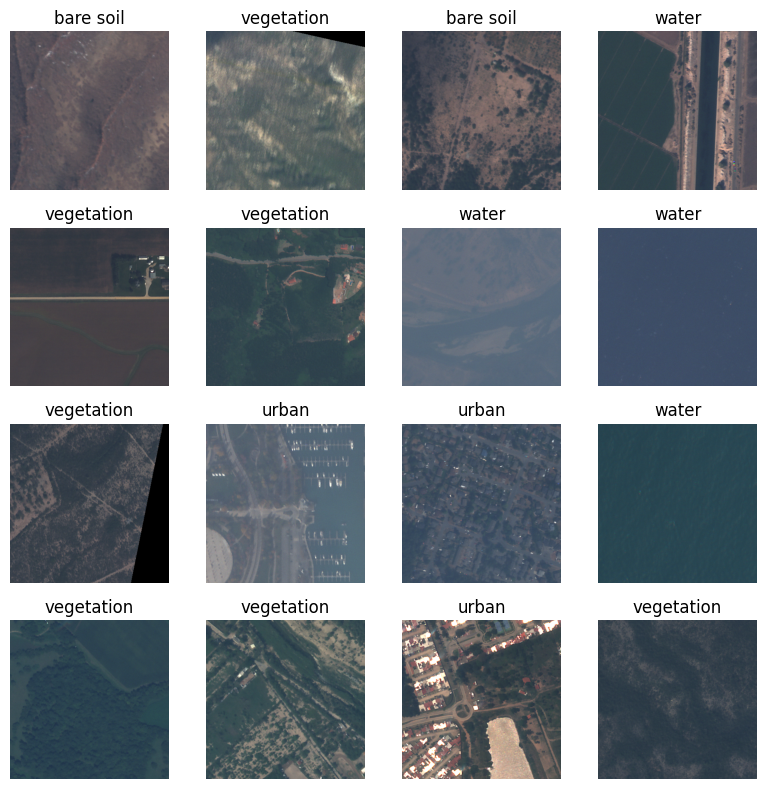

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()
images, labels = next(iter(dm.train_dataloader()))
for i in range(16):
    img = images[i].numpy().transpose(1,2,0)
    axes[i].imshow(img)
    class_indices = np.where(labels[i].numpy() == 1)[0]
    class_names = [dm.classes[idx] for idx in class_indices]
    axes[i].set_title(', '.join(class_names))
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [5]:
from eotdl.pytorch.classification import MultiLabelClassificationModule

module = MultiLabelClassificationModule(num_classes=4)

outputs = module(images)
outputs.shape

torch.Size([16, 4])

In [6]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import albumentations as A
import lightning as L

train_trans=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5)
])

dm = SCANEOClassificationDataModule(
    path='data', 
    classes=['bare soil', 'urban', 'vegetation', 'water'], 
    batch_size=4, 
    num_workers=0, 
    pin_memory=False,
    train_trans=train_trans
)
module = MultiLabelClassificationModule(num_classes=dm.num_classes)

trainer = L.Trainer(
    max_epochs=10,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=1,
    logger=CSVLogger('logs', name='classification'),
    callbacks=[ModelCheckpoint(
        monitor='val_acc', mode='max', save_top_k=1, save_last=True,
        dirpath='checkpoints', filename='classification-{epoch}-{val_acc:.2f}'
    )],
    log_every_n_steps=2,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/pipeline/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ClassificationModel | 11.2 M | train
1 | loss      | BCEWithLogitsLos

Training on 76 images
Validating on 19 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


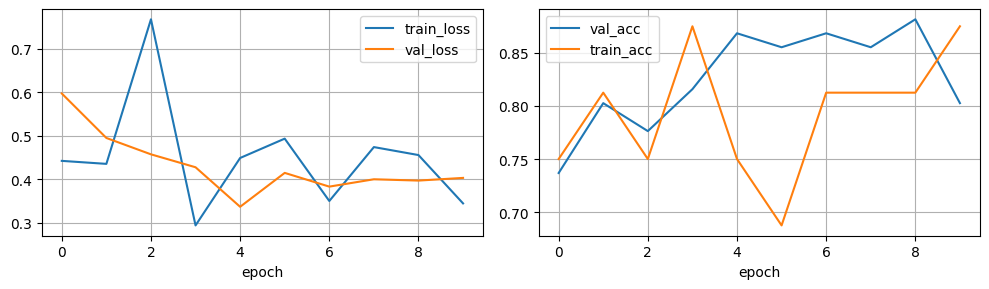

In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/classification'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/classification/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_acc', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

What if we use our pretrained model from https://www.eotdl.com/pipelines/UnsupervisedLearning ?

In [19]:
train_trans=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5)
])

dm = SCANEOClassificationDataModule(
    path='data', 
    classes=['bare soil', 'urban', 'vegetation', 'water'], 
    batch_size=4, 
    num_workers=0, 
    pin_memory=False,
    train_trans=train_trans
)
module = MultiLabelClassificationModule(num_classes=dm.num_classes, ssl='checkpoints/sat-last.ckpt')

trainer = L.Trainer(
    max_epochs=10,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=1,
    logger=CSVLogger('logs', name='classification'),
    callbacks=[ModelCheckpoint(
        monitor='val_acc', mode='max', save_top_k=1, save_last=False,
        dirpath='checkpoints', filename='classification-{epoch}-{val_acc:.2f}'
    )],
    log_every_n_steps=2,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading SSL checkpoint from checkpoints/sat-last.ckpt


/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/pipeline/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ClassificationModel | 11.2 M | train
1 | loss      | BCEWithLogitsLoss   | 0      | train
2 | train_acc | MultilabelAccuracy  | 0      | train
3 | val_acc   | MultilabelAccuracy  | 0      | train
----------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)
98        Modules in train mode
0         Modules in eval mode


Training on 76 images
Validating on 19 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


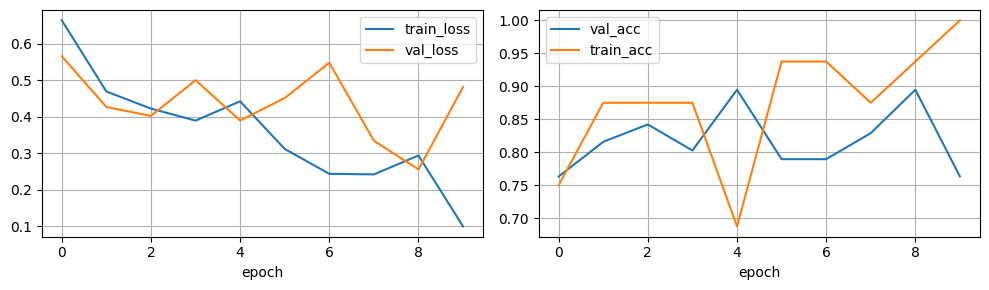

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/classification'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/classification/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_acc', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

Looks like we get a better model !

We can export the model to ONNX

In [21]:
# put here your best model !

module = MultiLabelClassificationModule.load_from_checkpoint('checkpoints/classification-epoch=4-val_acc=0.89.ckpt')

Loading SSL checkpoint from checkpoints/sat-last.ckpt


In [22]:
import torch

export_model = torch.nn.Sequential(
    module,
    torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [25]:
os.makedirs('outputs', exist_ok=True)

In [26]:
torch.onnx.export(
	export_model,
	images,
	'outputs/classification.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

In [27]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/classification.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(16, 4)

In [28]:
from torchmetrics.classification import MultilabelAccuracy

metric = MultilabelAccuracy(num_labels=4)

for batch in dm.val_dataloader():
    images, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds = ort_outs[0]
    metric(torch.from_numpy(preds), labels)

metric.compute()

tensor(0.8947)

# Segmentation

We train now a model with the segmentation labels.

In [30]:
from eotdl.pytorch.segmentation import SCANEOSegmentationDataModule

dm = SCANEOSegmentationDataModule('data')

dm.setup()

Training on 76 images
Validating on 19 images


In [31]:
batch = next(iter(dm.train_dataloader()))

images, masks = batch

images.shape, masks.shape

(torch.Size([16, 3, 384, 384]), torch.Size([16, 5, 384, 384]))

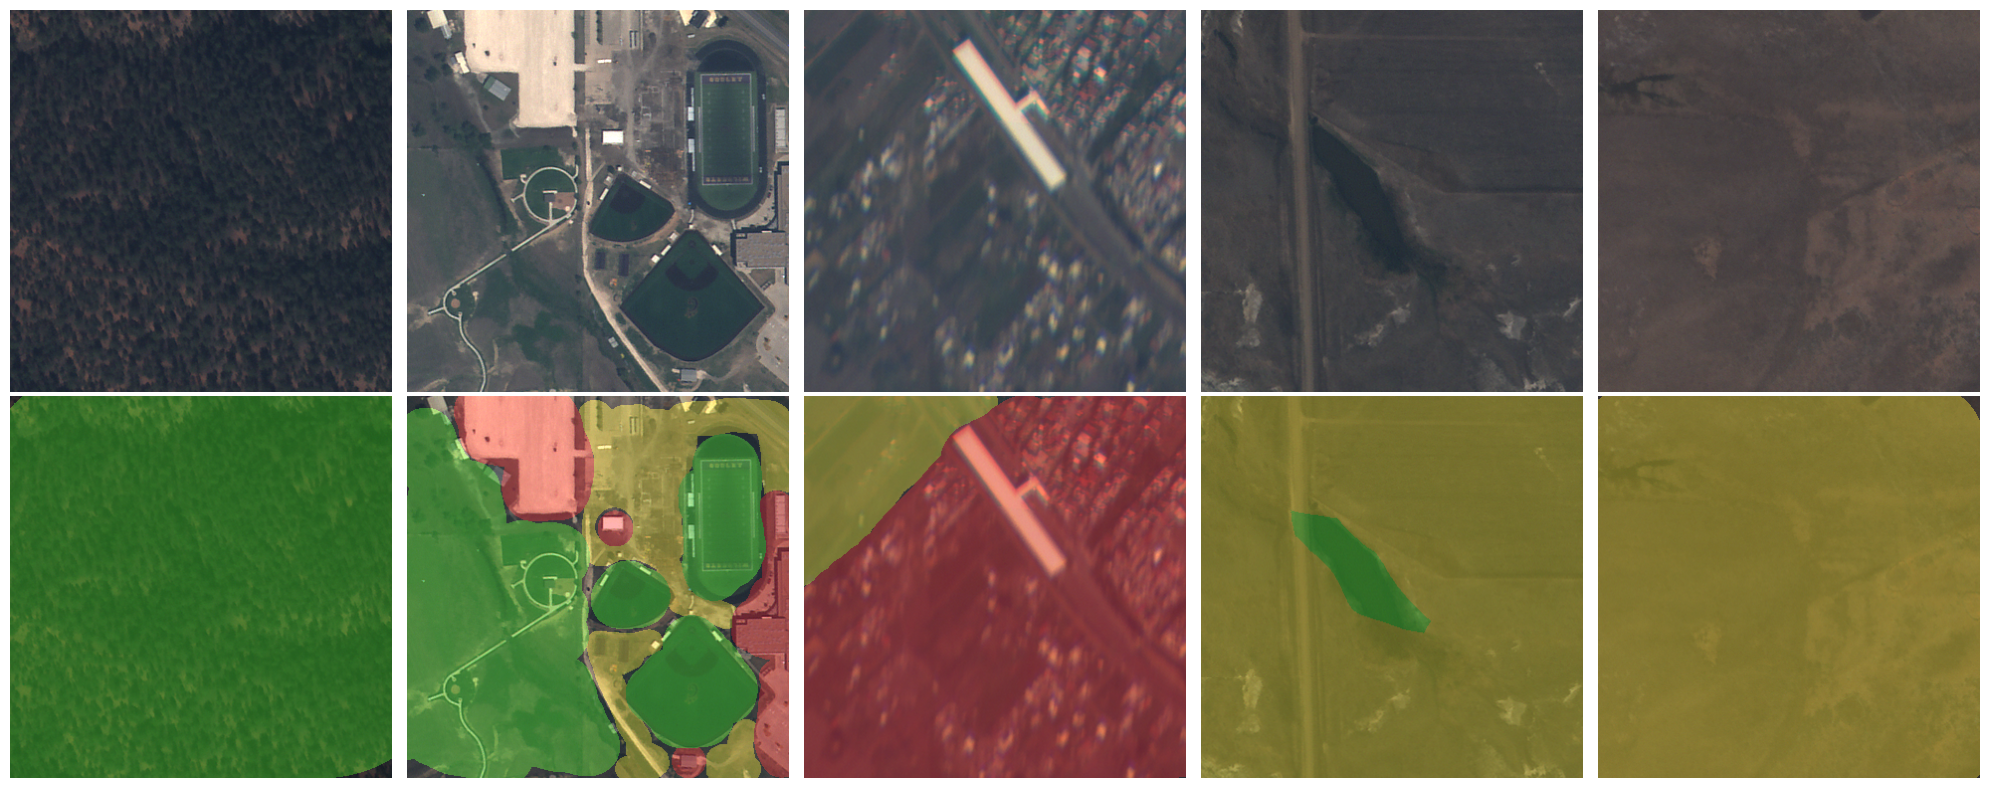

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
_colors = ['#000000'] + [ dm.colors.get(l) for l in list(dm.colors.keys()) ]
cmap = ListedColormap(_colors)

batch = next(iter(dm.train_dataloader()))
images, masks = batch
for i in range(5):
    axes[0, i].imshow(images[i].permute(1,2,0))
    axes[0, i].axis('off')    
    axes[1, i].imshow(images[i].permute(1,2,0))
    axes[1, i].imshow(masks[i].argmax(0), cmap=cmap, vmin=0, vmax=len(dm.colors)+1, alpha=0.3)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [33]:
from eotdl.pytorch.segmentation import SegmentationModule

module = SegmentationModule()

outputs = module(images)

outputs.shape

torch.Size([16, 6, 384, 384])

In [36]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import albumentations as A

dm = SCANEOSegmentationDataModule('data', batch_size=16, num_workers=0, pin_memory=False, train_trans=A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5)
]))
module = SegmentationModule(num_classes=dm.num_classes)

trainer = L.Trainer(
    max_epochs=10,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=1,
    logger=CSVLogger('logs', name='segmentation'),
    callbacks=[ModelCheckpoint(
        monitor='val_iou', mode='max', save_top_k=1, save_last=False,
        dirpath='checkpoints', filename='segmentation-{epoch}-{val_iou:.2f}'
    )],
    log_every_n_steps=1,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/pipeline/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | SegmentationModel | 14.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.379    Total estimated model params size (MB)
144       Modules in train mode
0         Modules in eval mode


Training on 76 images
Validating on 19 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


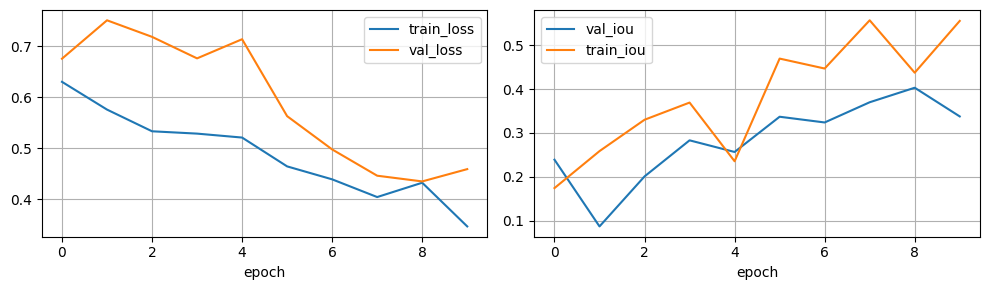

In [37]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/segmentation'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/segmentation/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_iou', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

> Train for longer to get a better model !

We can export to ONNX

In [38]:
# put here your best model !

module = SegmentationModule.load_from_checkpoint('checkpoints/segmentation-epoch=8-val_iou=0.40.ckpt')


In [39]:
import torch

export_model = torch.nn.Sequential(
    module,
    # torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [40]:
torch.onnx.export(
	export_model,
	images,
	'outputs/segmentation.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

In [41]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/segmentation.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(16, 5, 384, 384)

In [43]:
from eotdl.pytorch.segmentation.metrics import iou

metrics = []
for batch in dm.val_dataloader():
    images, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds = ort_outs[0]
    metrics.append(iou(torch.from_numpy(preds), labels))

np.mean(metrics)

0.49739224

# Multitask Learning

We now train one model for both tasks at the same time!

In [44]:
from eotdl.pytorch.multitasking import SCANEOMultiTaskDataModule

dm = SCANEOMultiTaskDataModule('data', classes=['bare soil', 'urban', 'vegetation', 'water'])

dm.setup()

Training on 76 images
Validating on 19 images


In [45]:
batch = next(iter(dm.train_dataloader()))

images, masks, labels = batch

images.shape, masks.shape, labels.shape

(torch.Size([16, 3, 384, 384]),
 torch.Size([16, 5, 384, 384]),
 torch.Size([16, 4]))

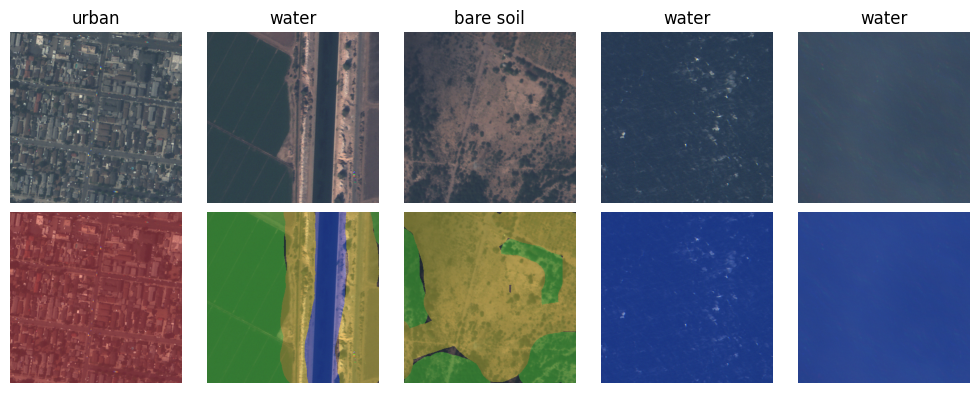

In [46]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
_colors = ['#000000'] + [ dm.colors.get(l) for l in list(dm.colors.keys()) ]
cmap = ListedColormap(_colors)

batch = next(iter(dm.train_dataloader()))
images, masks, labels = batch
for i in range(5):
    axes[0, i].imshow(images[i].permute(1,2,0))
    axes[0, i].axis('off')    
    class_indices = np.where(labels[i].numpy() == 1)[0]
    class_names = [dm.classification_classes[idx] for idx in class_indices]
    axes[0, i].set_title(', '.join(class_names))
    axes[1, i].imshow(images[i].permute(1,2,0))
    axes[1, i].imshow(masks[i].argmax(0), cmap=cmap, vmin=0, vmax=len(dm.colors)+1, alpha=0.3)
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [47]:
from eotdl.pytorch.multitasking import MultiTaskModule

module = MultiTaskModule()

seg_preds, cls_preds = module(images)

seg_preds.shape, cls_preds.shape

(torch.Size([16, 4, 384, 384]), torch.Size([16, 4]))

In [48]:
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import albumentations as A


dm = SCANEOMultiTaskDataModule(
    'data', 
    classes=['bare soil', 'urban', 'vegetation', 'water'], 
    batch_size=16, 
    num_workers=4, 
    pin_memory=False, 
    train_trans=A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5)
    ])
)
module = MultiTaskModule(num_seg_classes=dm.num_seg_classes, num_cls_classes=dm.num_cls_classes)

trainer = L.Trainer(
    max_epochs=10,
    precision='bf16-mixed',
    accelerator='gpu',
    devices=1,
    logger=CSVLogger('logs', name='multitask'),
    callbacks=[
        ModelCheckpoint(    
            monitor='val_acc', mode='max', save_top_k=1, save_last=False,
            dirpath='checkpoints', filename='multitask-{epoch}-{val_acc:.2f}'
        ), 
        ModelCheckpoint(
            monitor='val_iou', mode='max', save_top_k=1, save_last=False,
            dirpath='checkpoints', filename='multitask-{epoch}-{val_iou:.2f}'
        )
    ],
    log_every_n_steps=1,
)

trainer.fit(module, dm)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/juan/Desktop/eotdl/tutorials/usecases/useCaseC/pipeline/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | model         | MultiTaskModel     | 14.3 M | train
1 | seg_loss      | BCEWithLogitsLoss  | 0      | train
2 | cls_loss      | BCEWithLogitsLoss  | 0      | train
3 | train_cls_acc | MultilabelAccuracy | 0      | train
4 | val_cls_acc   | MultilabelAccuracy | 0      | train
-------------------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.387    Total esti

Training on 76 images
Validating on 19 images


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


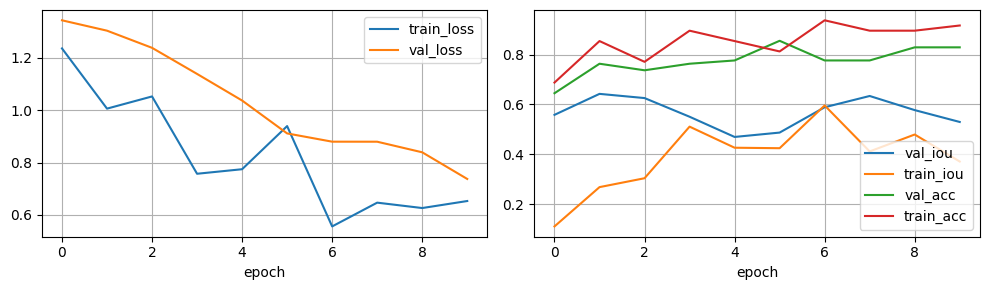

In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/multitask'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/multitask/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='val_acc', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_acc', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()

Training both modalities at the same time is a bit more difficult, but segmentations results are much better although classification results are worse. Training longer should improve both and get a better model than training them separately.

> Train for longer to get a better model !

We can export the model to ONNX format

In [50]:
# put here your best model !

module = MultiTaskModule.load_from_checkpoint('checkpoints/multitask-epoch=5-val_acc=0.86.ckpt')


In [51]:
import torch

export_model = torch.nn.Sequential(
    module,
    # torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [52]:
torch.onnx.export(
	export_model,
	images,
	'outputs/multitask.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['seg_preds', 'cls_preds'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'seg_preds': {
			0: 'batch_size'
		},
		'cls_preds': {
			0: 'batch_size'
		}
	}
)

In [53]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/multitask.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape, ort_outs[1].shape

((16, 5, 384, 384), (16, 4))

In [55]:
from eotdl.pytorch.segmentation.metrics import iou
from torchmetrics.classification import MultilabelAccuracy

metrics = []
metric = MultilabelAccuracy(num_labels=4)

for batch in dm.val_dataloader():
    images, masks, labels = batch
    ort_inputs = {input_name: images.numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    preds_seg, preds_cls = ort_outs
    metrics.append(iou(torch.from_numpy(preds_seg), masks))
    metric(torch.from_numpy(preds_cls), labels)

np.mean(metrics), metric.compute()

(0.49703467, tensor(0.8684))

Enjoy your models!

You can use the script `inference.py` to start an API locally to use your models. Test the API with the notebook `inference.ipynb` and connect it to SCANEO to perform assisted labelling on new data!